## Benchmarking notebook for decentralized energy trading

#### To run please start the following services:
- Parity Container: ```yarn run-benchmark-node```
- Benchmarking Ned Server: ```yarn run-benchmark-ned```


### Imports

In [1]:
%%capture
!{sys.executable} -m pip install matplotlib
import sys
import json
import csv
import os
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import matplotlib.pyplot as plt
import math
import numpy as np



### Configuration
- n - max. number of households to be benchmarked
- step - number of households to be skiped for each iteration
- shareProducers - share of producing households


In [ ]:
n = 100
step = 20
shareProducers = 0.1

### Helper Functions

In [3]:
witness_time = []
proof_time = []
compile_time = []
setup_time = []
gas = []

# balances producers and consumers for given num of households based on shareProducers
def calcProducerConsumer(num):
    if num == 0:
        wE = 1
        nE = 1
    else:
        wE = math.ceil(num * shareProducers)
        nE = num - wE
    return wE, nE

# creates list of tupels containing prododucers and consumers numbers
def createhhNumbers():
    number_of_tests = int((n / step) + 1)
    res = []
    for i in range(number_of_tests):
        res.append(calcProducerConsumer(i * step))
    print(res)
    return res

# parses data csv file
def parseData():
    with open('../tmp/res.csv') as file:
        data = list(csv.reader(file))
        for entry in data:
            witness_time.append(entry[0])
            proof_time.append(entry[1])
            gas.append(entry[2])

# removes data from file
def reset_files():
    !pwd
    f = open("tmp/res.csv", "w+")
    f.write("")
    f.close()

### Run Benchmark

In [ ]:
%cd ..
reset_files()
hhNumbers = createhhNumbers()

for i in hhNumbers:
    %cd zokrates-code
    !node zoKratesCodeGenerator.js {i[0]} {i[1]} benchmark
    !zokrates compile -i settlement-check.zok --light
    !zokrates setup --light
    !zokrates export-verifier
    !cp ./verifier.sol ../contracts/verifier.sol
    %cd ..
    print("Compiling and deploying Contracts...")
    # !! executes bash command and captures output. If errors appear, remove one ! to debug
    !!truffle migrate --reset hard --network benchmark
    !node benchmark/setup_benchmark.js {i[0]} {i[1]}
    input("wait until netting has been successful..")
%cd benchmark

### Cost for Netting:

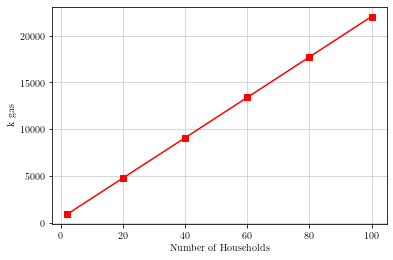

In [11]:
x_label = list(map(lambda x: x[0] + x[1], hhNumbers))
parseData()

ax = plt.plot(x_label, [int(x) / 1000 for x in gas], '-rs')
plt.xlabel('Number of Households')
plt.ylabel('k gas')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
plt.savefig('exports/gas.eps', format='eps')

### Witness and Proof Time:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


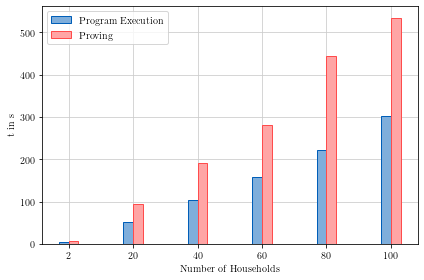

In [8]:
x = np.arange(len(x_label))  # the label locations
width = 0.15  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [float(x) / 1000 for x in witness_time], width, label='Program Execution', edgecolor='#005eb8', color='#7faedb', zorder=3)
rects2 = ax.bar(x + width/2, [float(x) / 1000 for x in proof_time], width, label='Proving', edgecolor='#ff4c4c', color='#ffa5a5', zorder=3)
ax.set_ylabel('t in s')
ax.set_xticks(x)
ax.set_xlabel('Number of Households')
ax.set_xticklabels(x_label)
ax.legend()
ax.grid(zorder=0)
fig.tight_layout()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
fig.savefig('exports/exec.eps', format='eps')
plt.show()